### Import Relevant Libraries

In [1]:
import geopandas as gpd # Geopandas for storing Shapely objects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata
import os
import gzip
import numpy as np
import re
import shapely
from shapely.geometry import Polygon, Point # Representing bins and cells as Shapely Polygons and Point objects
from shapely import wkt

In [2]:
import glob
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from shapely.validation import make_valid

# ====== 你的三个算法函数（需确保已定义） ======
def naive_assignment(bin_gdf, cell_gdf):
    spatial_join = gpd.sjoin(
        gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
        gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
        how="inner", predicate="within"
    )
    spatial_join["cell_id"] = spatial_join["index_right"].map(cell_gdf["cell_id"])
    genes = [col for col in bin_gdf.columns if col not in ['assigned_bin_id','row','column','geometry']]
    result = spatial_join.groupby("cell_id")[genes].sum()
    return result

def weighted_by_area(bin_gdf, cell_gdf):
    genes = [col for col in bin_gdf.columns if col not in ['assigned_bin_id','row','column','geometry']]
    spatial_join = gpd.sjoin(
        gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
        gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
        how="inner", predicate="intersects"
    )
    def safe_intersection(bin_geom, cell_geom):
        try: return bin_geom.intersection(cell_geom).area
        except: return 0
    spatial_join["overlap_area"] = spatial_join.apply(
        lambda row: safe_intersection(row["geometry"], cell_gdf.loc[row["index_right"], "geometry"]),
        axis=1
    )
    spatial_join["bin_area"] = spatial_join["geometry"].apply(lambda x: x.area)
    spatial_join["weight"] = spatial_join["overlap_area"] / spatial_join["bin_area"]
    spatial_join["cell_id"] = spatial_join["index_right"].map(cell_gdf["cell_id"])
    gene_weighted = spatial_join[genes].multiply(spatial_join["weight"], axis=0)
    gene_weighted["cell_id"] = spatial_join["cell_id"]
    res = gene_weighted.groupby("cell_id")[genes].sum()
    return res

def weighted_area_distance(bin_gdf, cell_gdf, alpha=0.01):
    genes = [col for col in bin_gdf.columns if col not in ['assigned_bin_id','row','column','geometry']]
    spatial_join = gpd.sjoin(
        gpd.GeoDataFrame(bin_gdf, geometry='geometry'),
        gpd.GeoDataFrame(cell_gdf, geometry='geometry'),
        how="inner", predicate="intersects"
    )
    spatial_join["geometry"] = spatial_join["geometry"].apply(lambda g: make_valid(g) if not g.is_valid else g)
    cell_gdf['geometry'] = cell_gdf['geometry'].apply(lambda g: make_valid(g) if not g.is_valid else g)
    def safe_intersection(bin_geom, cell_geom):
        try: return bin_geom.intersection(cell_geom).area
        except: return 0
    spatial_join["overlap_area"] = spatial_join.apply(
        lambda row: safe_intersection(row["geometry"], cell_gdf.loc[row["index_right"], "geometry"]),
        axis=1
    )
    spatial_join["bin_area"] = spatial_join["geometry"].apply(lambda x: x.area)
    spatial_join["area_weight"] = spatial_join["overlap_area"] / spatial_join["bin_area"]
    # 距离权重
    spatial_join["bin_center_x"] = spatial_join["geometry"].apply(lambda g: g.centroid.x)
    spatial_join["bin_center_y"] = spatial_join["geometry"].apply(lambda g: g.centroid.y)
    cell_gdf["centroid_x"] = cell_gdf["geometry"].apply(lambda g: g.centroid.x)
    cell_gdf["centroid_y"] = cell_gdf["geometry"].apply(lambda g: g.centroid.y)
    spatial_join["cell_center_x"] = spatial_join["index_right"].map(cell_gdf["centroid_x"])
    spatial_join["cell_center_y"] = spatial_join["index_right"].map(cell_gdf["centroid_y"])
    spatial_join["eucl_dist"] = ((spatial_join["bin_center_x"] - spatial_join["cell_center_x"])**2 + 
                                 (spatial_join["bin_center_y"] - spatial_join["cell_center_y"])**2)**0.5
    spatial_join["dist_weight"] = np.exp(-alpha * spatial_join["eucl_dist"])
    spatial_join["raw_weight"] = spatial_join["area_weight"] * spatial_join["dist_weight"]
    weight_norm = spatial_join.groupby("assigned_bin_id")["raw_weight"].transform(lambda x: x / x.sum())
    spatial_join["weight"] = weight_norm.fillna(0)
    spatial_join["cell_id"] = spatial_join["index_right"].map(cell_gdf["cell_id"])
    gene_weighted = spatial_join[genes].multiply(spatial_join["weight"], axis=0)
    gene_weighted["cell_id"] = spatial_join["cell_id"]
    res = gene_weighted.groupby("cell_id")[genes].sum()
    return res

# ====== 批量计算、容错 ======
patch_files = sorted(glob.glob("/home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/patch_*.csv"))
results = []

for bin_path in patch_files:
    patch_name = bin_path.split('/')[-1]
    cell_path = bin_path.replace('bins_gdf', 'cells_gdf')
    gt_path = bin_path.replace('bins_gdf', 'ground_truth_nuclei')
    
    if not (os.path.exists(cell_path) and os.path.exists(gt_path)):
        print(f"skip {patch_name}: cells or gt missing.")
        continue
    
    try:
        bin_gdf = pd.read_csv(bin_path)
        bin_gdf['geometry'] = bin_gdf['geometry'].apply(wkt.loads)
        cell_gdf = pd.read_csv(cell_path)
        cell_gdf['geometry'] = cell_gdf['geometry'].apply(wkt.loads)
        gt = pd.read_csv(gt_path).set_index("cell_id")
        gt = gt.apply(pd.to_numeric, errors='coerce').fillna(0)
    except Exception as e:
        print(f"skip {patch_name}: {e}")
        continue
    
    if cell_gdf.empty or gt.empty:
        print(f"skip {patch_name}: no cells or ground truth")
        continue

    common_genes = list(set(bin_gdf.columns) & set(gt.columns) - set(['assigned_bin_id','row','column','geometry']))

    try:
        # Naive
        pred_naive = naive_assignment(bin_gdf, cell_gdf)
        pred1 = pred_naive.reindex(index=gt.index, columns=common_genes, fill_value=0).astype(float)
        min_sum = np.minimum(pred1.values, gt[common_genes].values).sum()
        pred_sum = pred1.values.sum()
        truth_sum = gt[common_genes].values.sum()
        pr1 = min_sum / pred_sum if pred_sum > 0 else 0
        rc1 = min_sum / truth_sum if truth_sum > 0 else 0
        f11 = 2 * pr1 * rc1 / (pr1 + rc1) if (pr1 + rc1) else 0

        # Weighted Area
        pred_wa = weighted_by_area(bin_gdf, cell_gdf)
        pred2 = pred_wa.reindex(index=gt.index, columns=common_genes, fill_value=0).astype(float)
        min_sum = np.minimum(pred2.values, gt[common_genes].values).sum()
        pred_sum = pred2.values.sum()
        pr2 = min_sum / pred_sum if pred_sum > 0 else 0
        rc2 = min_sum / truth_sum if truth_sum > 0 else 0
        f12 = 2 * pr2 * rc2 / (pr2 + rc2) if (pr2 + rc2) else 0

        # SPHERE (alpha可调)
        pred_dma = weighted_area_distance(bin_gdf, cell_gdf, alpha=0.01)
        pred3 = pred_dma.reindex(index=gt.index, columns=common_genes, fill_value=0).astype(float)
        min_sum = np.minimum(pred3.values, gt[common_genes].values).sum()
        pred_sum = pred3.values.sum()
        pr3 = min_sum / pred_sum if pred_sum > 0 else 0
        rc3 = min_sum / truth_sum if truth_sum > 0 else 0
        f13 = 2 * pr3 * rc3 / (pr3 + rc3) if (pr3 + rc3) else 0

        results.append({
            "patch": patch_name,
            "naive_precision": pr1,
            "naive_recall": rc1,
            "naive_f1": f11,
            "area_precision": pr2,
            "area_recall": rc2,
            "area_f1": f12,
            "dmaa_precision": pr3,
            "dmaa_recall": rc3,
            "dmaa_f1": f13
        })
    except Exception as e:
        print(f"skip {patch_name} in algorithm: {e}")

df = pd.DataFrame(results)
df.to_csv("patch_metrics_HumanCRC.csv", index=False)
print("All finished! Results saved to patch_metrics_HumanCRC.csv")

All finished! Results saved to patch_metrics_HumanCRC.csv


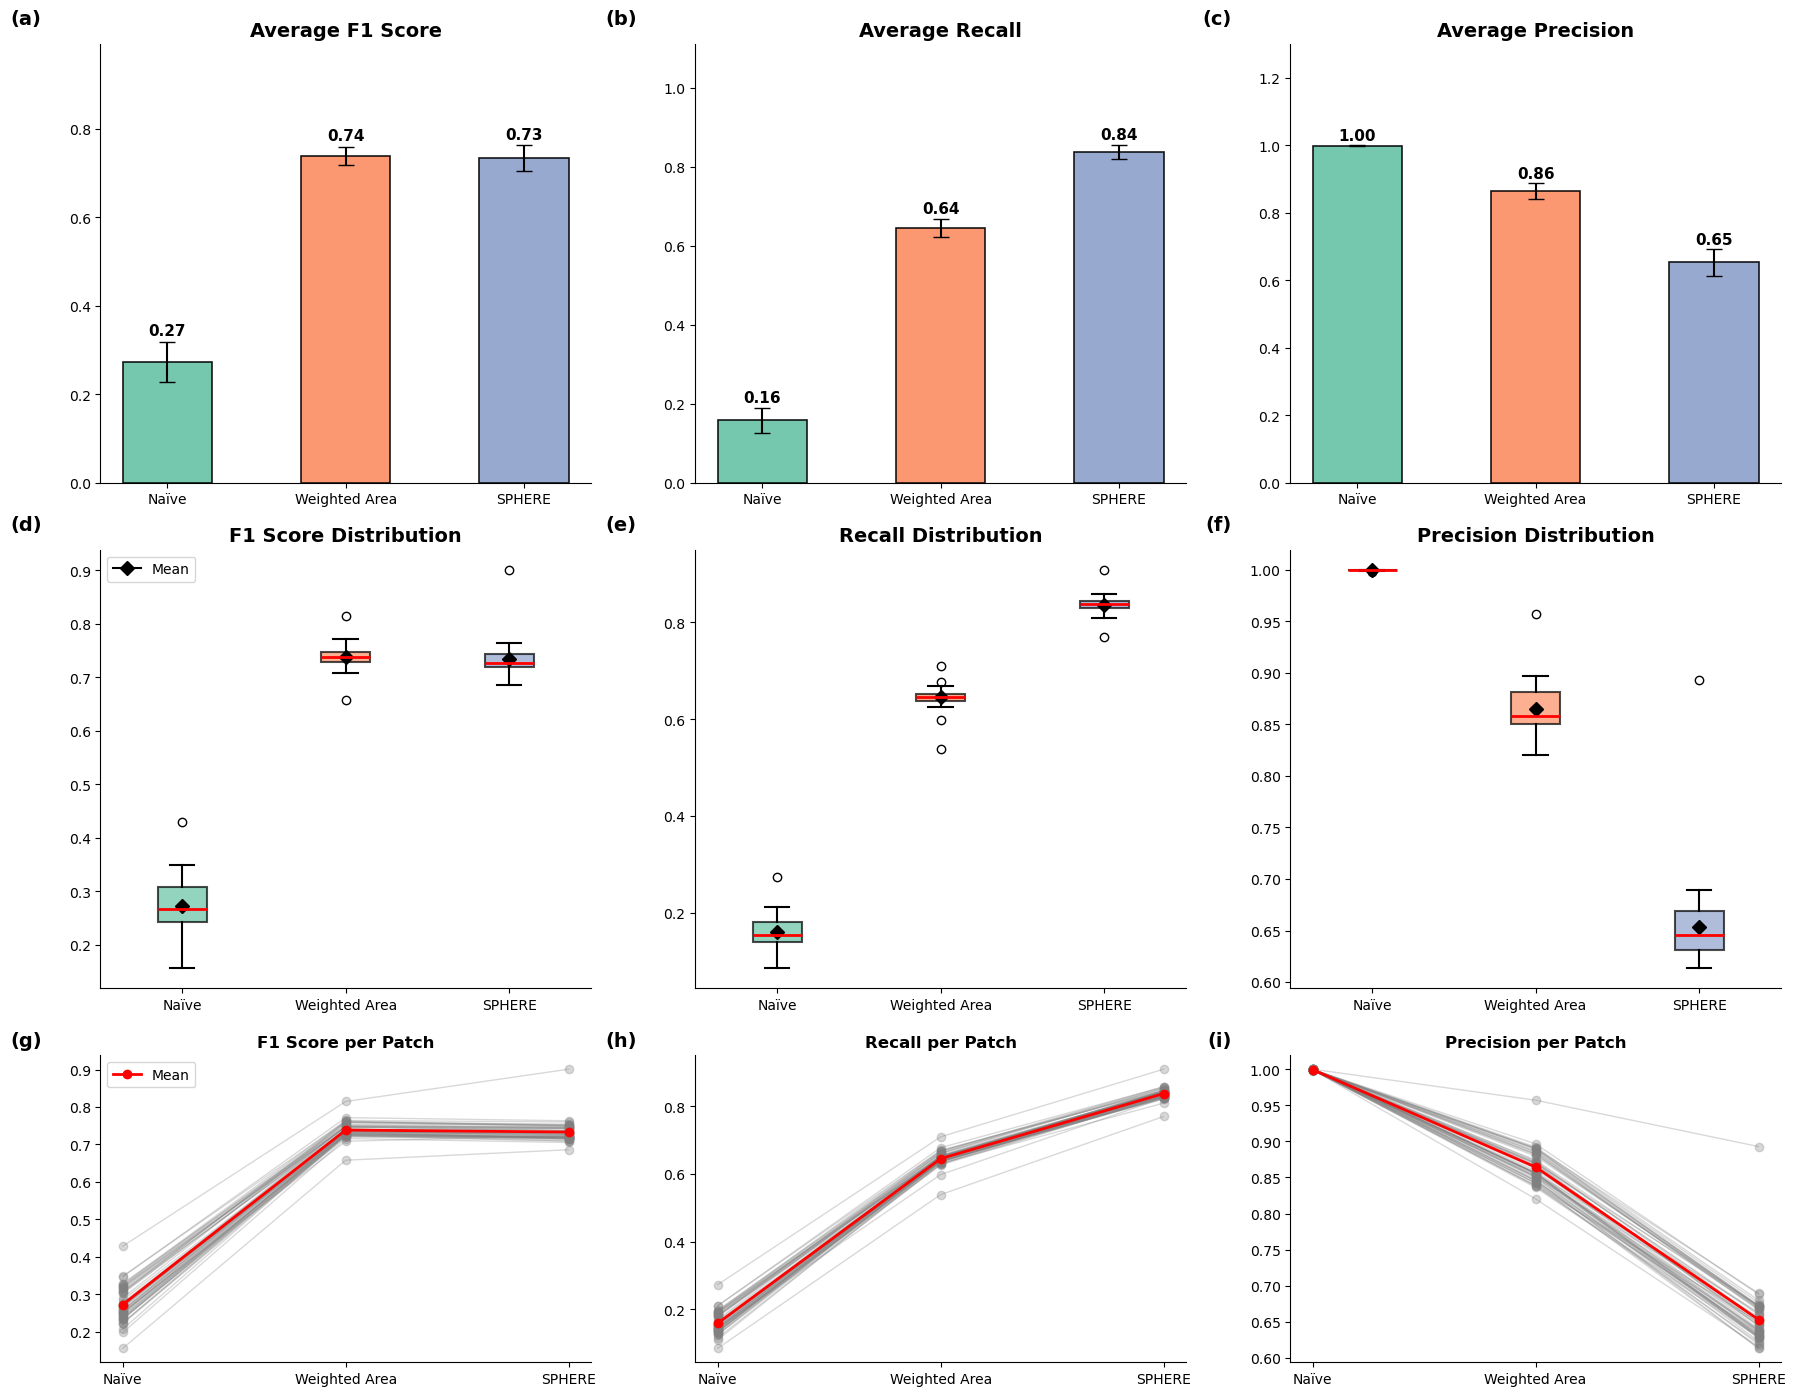

In [5]:
import glob
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import string

# 三个方法标签
methods = ["Naïve", "Weighted Area", "SPHERE"]

# 三个方法颜色
colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

# 要画的三个指标及对应的列名
metrics_info = {
    "F1 Score": ["naive_f1", "area_f1", "dmaa_f1"],
    "Recall": ["naive_recall", "area_recall", "dmaa_recall"],
    "Precision": ["naive_precision", "area_precision", "dmaa_precision"]
}

def plot_core_metrics(df, save_prefix=None):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14),
                             gridspec_kw={'height_ratios':[1, 1, 0.7]})
    subplot_labels = list(string.ascii_lowercase)
    label_idx = 0
    label_x, label_y = -0.12, 1.08

    for row_idx in range(3):
        for col_idx, (metric_name, cols) in enumerate(metrics_info.items()):
            ax = axes[row_idx, col_idx]
            data = [df[col] for col in cols]
            means = [d.mean() for d in data]
            stds  = [d.std() for d in data]

            if row_idx == 0:
                ax.bar(methods, means, yerr=stds, capsize=6, width=0.5,
                       color=colors, edgecolor='black', linewidth=1.2, alpha=0.9)
                for i, (v, s) in enumerate(zip(means, stds)):
                    ax.text(i, v + s + 0.015, f"{v:.2f}",
                            ha='center', fontsize=11, fontweight='bold')
                ax.set_ylim(0, max([m+s for m,s in zip(means, stds)]) * 1.3)
                ax.set_title(f"Average {metric_name}", fontsize=14, fontweight='bold')

            elif row_idx == 1:
                bp = ax.boxplot(
                    data, labels=methods, patch_artist=True,
                    medianprops=dict(color='red', linewidth=2),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5)
                )
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                for i, arr in enumerate(data):
                    ax.plot([i+1], [np.mean(arr)], marker='D',
                            color='black', markersize=7,
                            label='Mean' if (i == 0 and col_idx == 0) else None)
                ax.set_title(f"{metric_name} Distribution", fontsize=14, fontweight='bold')

            elif row_idx == 2:
                for _, row in df[cols].iterrows():
                    ax.plot(methods, row, marker='o', alpha=0.3,
                            color='gray', linewidth=1)
                ax.plot(methods, df[cols].mean(), marker='o',
                        color='red', linewidth=2, label='Mean')
                ax.set_title(f"{metric_name} per Patch", fontsize=12, fontweight='bold')

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            if row_idx in [1, 2] and col_idx == 0:
                ax.legend()
            ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
                    transform=ax.transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='right')
            label_idx += 1

    fig.tight_layout()
    if save_prefix:
        fig.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{save_prefix}.pdf", bbox_inches="tight")
    plt.show()

# ===== 调用 =====
df = pd.read_csv("patch_metrics_HumanCRC.csv")
plot_core_metrics(df, "figure2_HumanCRC")

In [6]:
def plot_supplementary(df, save_prefix=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    subplot_labels = list(string.ascii_lowercase)  # a, b, c...
    label_idx = 0
    label_x, label_y = -0.12, 1.08

    # ==== a: F1 Improvement ====
    base_col = metrics_info["F1 Score"][0]
    imp_data, imp_labels = [], []
    for method, col in zip(methods[1:], metrics_info["F1 Score"][1:]):
        imp = (df[col] - df[base_col]) / df[base_col] * 100
        imp_data.append(imp)
        imp_labels.append(f"{method} vs Naive")
    ax = axes[0, 0]
    bp = ax.boxplot(
        imp_data, labels=imp_labels, patch_artist=True,
        medianprops=dict(color='red', linewidth=2),
        boxprops=dict(linewidth=1.5),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )
    for patch, c in zip(bp['boxes'], colors[1:]):
        patch.set_facecolor(c); patch.set_alpha(0.7)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_ylabel("Improvement over Naive (%)")
    ax.set_title("F1 Improvement vs Naive", fontsize=13, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== b: Naive vs SPHERE scatter ====
    ax = axes[0, 1]
    ax.scatter(df['naive_f1'], df['dmaa_f1'], alpha=0.6, color='#6AB187', edgecolor='k')
    ax.plot([0,1],[0,1],'k--',lw=1)
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_xlabel('Naive F1'); ax.set_ylabel('SPHERE F1')
    ax.set_title("Naive vs SPHERE (F1)", fontsize=13, fontweight='bold')
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== c: F1 KDE ====
    ax = axes[0, 2]
    for col, color, m in zip(metrics_info["F1 Score"], colors, methods):
        sns.kdeplot(df[col], fill=True, alpha=0.4,
                    color=color, label=m, ax=ax, linewidth=1.2)
    ax.set_xlabel("F1 Score"); ax.set_ylabel("Density"); ax.legend()
    ax.set_title("F1 Score Distribution", fontsize=13, fontweight='bold')
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== d: Recall vs Precision scatter ====
    ax = axes[1, 0]
    ax.scatter(df['dmaa_recall'], df['dmaa_precision'],
               color=colors[2], alpha=0.6, edgecolor='k')
    ax.set_xlabel("Recall (SPHERE)"); ax.set_ylabel("Precision (SPHERE)")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_title("Recall vs Precision (SPHERE)", fontsize=13, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== e: F1 difference histogram ====
    ax = axes[1, 1]
    diff = df['dmaa_f1'] - df['naive_f1']
    ax.hist(diff, bins=15, color=colors[2], alpha=0.7, edgecolor='black')
    ax.set_xlabel("F1 Difference (SPHERE − Naive)")
    ax.set_ylabel("Count")
    ax.set_title("F1 Difference Histogram", fontsize=13, fontweight='bold')
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')
    label_idx += 1

    # ==== f: Win-rate heatmap ====
    ax = axes[1, 2]
    win_rate = pd.DataFrame(index=methods)
    for metric_name, cols in metrics_info.items():
        ranks = df[cols].rank(axis=1, method='average', ascending=False)
        win_counts = (ranks == 1).sum(axis=0)
        win_rate[metric_name] = (win_counts / len(df) * 100).values
    sns.heatmap(win_rate, annot=True, fmt=".1f", cmap="YlGnBu",
                cbar=False, ax=ax)
    ax.set_title("Win-rate (%) by Metric", fontsize=13, fontweight='bold')
    ax.text(label_x, label_y, f"({subplot_labels[label_idx]})",
            transform=ax.transAxes, fontsize=14, fontweight='bold')

    fig.tight_layout()
    if save_prefix:
        fig.savefig(f"{save_prefix}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{save_prefix}.pdf", bbox_inches="tight")
    plt.show()

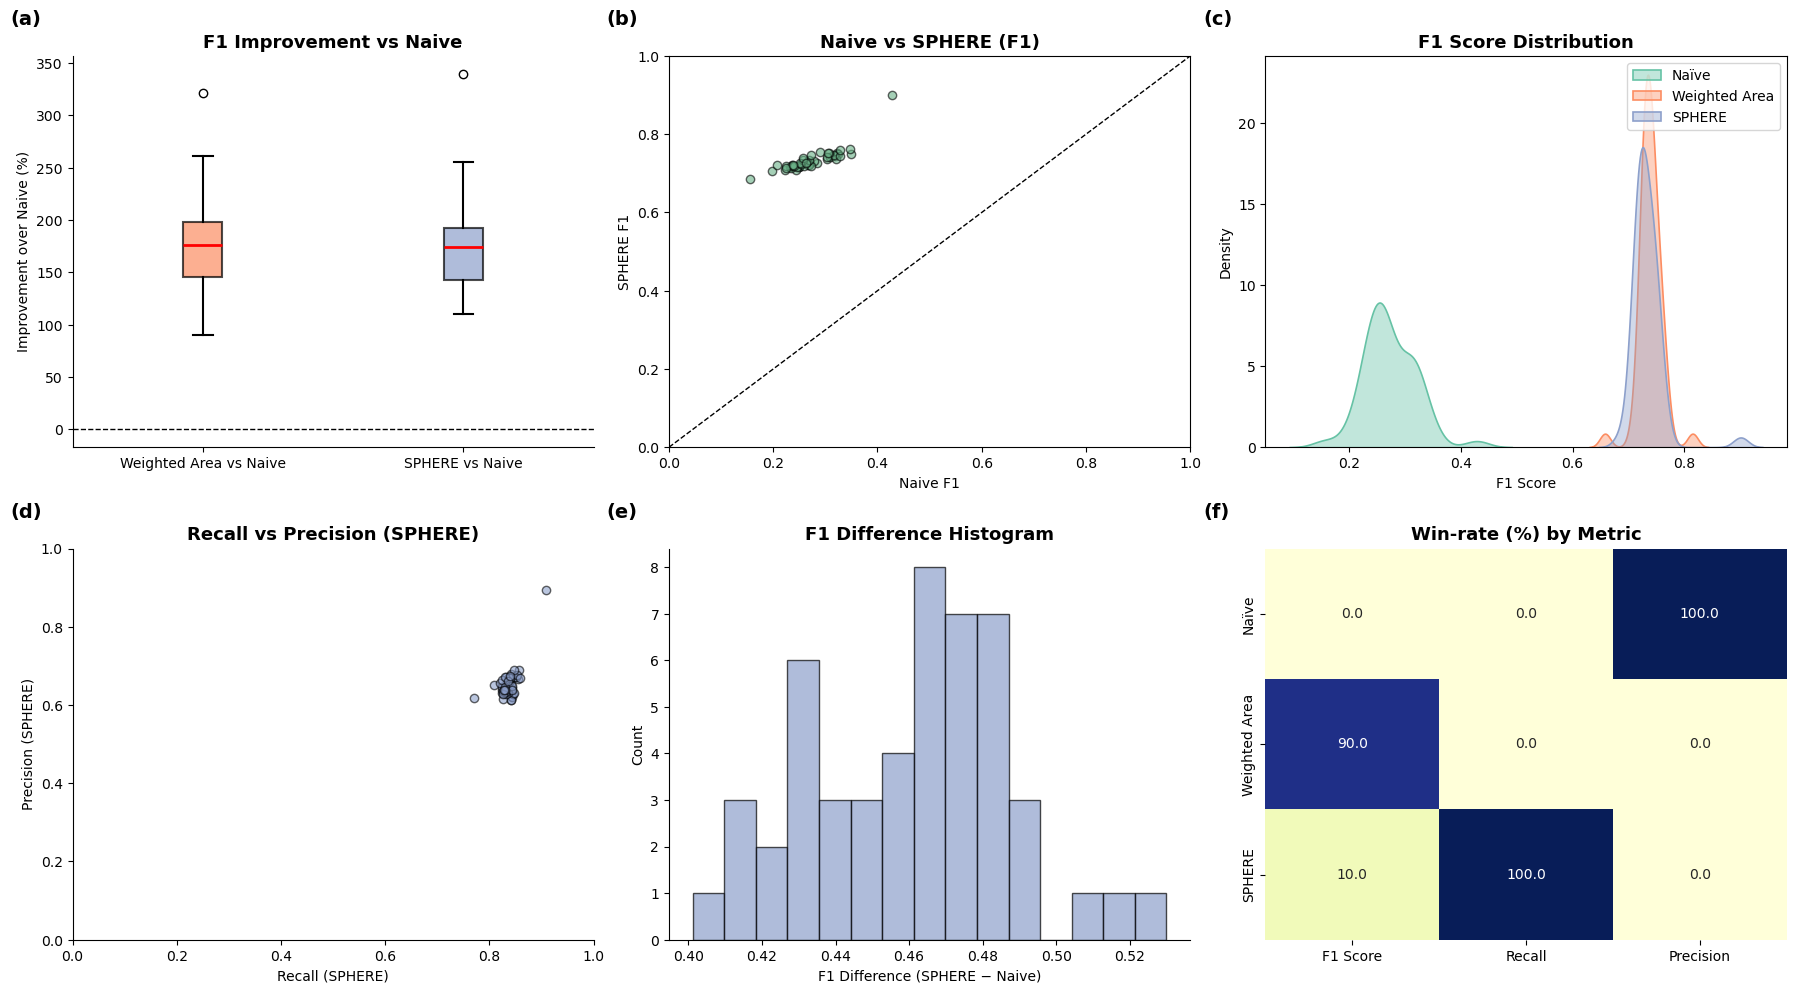

In [7]:
import seaborn as sns
plot_supplementary(df, "figure_supp_HumanCRC_simu")

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import scanpy as sc
import geopandas as gpd
from shapely import wkt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ===== 三种方法实现 =====
def naive_assignment(bin_gdf, cell_gdf, common_genes):
    sj = gpd.sjoin(gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
                   gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
                   how="inner", predicate="within")
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    return sj.groupby("cell_id")[common_genes].sum()

def weighted_by_area(bin_gdf, cell_gdf, common_genes):
    sj = gpd.sjoin(gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
                   gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
                   how="inner", predicate="intersects")
    def safe_intersection(g1, g2):
        try:
            return g1.intersection(g2).area
        except:
            return 0
    sj["overlap_area"] = sj.apply(
        lambda r: safe_intersection(r["geometry"], cell_gdf.loc[r["index_right"], "geometry"]), axis=1)
    sj["bin_area"] = sj["geometry"].area
    sj["weight"] = sj["overlap_area"] / sj["bin_area"]
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    weighted = sj[common_genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["cell_id"]
    return weighted.groupby("cell_id")[common_genes].sum()

def sphere_assignment(bin_gdf, cell_gdf, common_genes, alpha=0.01):
    sj = gpd.sjoin(gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
                   gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
                   how="inner", predicate="intersects")
    def safe_intersection(g1, g2):
        try:
            return g1.intersection(g2).area
        except:
            return 0
    sj["overlap_area"] = sj.apply(
        lambda r: safe_intersection(r["geometry"], cell_gdf.loc[r["index_right"], "geometry"]), axis=1)
    sj["bin_area"] = sj["geometry"].area
    sj["area_weight"] = sj["overlap_area"] / sj["bin_area"]

    # 距离权重
    sj["bin_cx"] = sj["geometry"].apply(lambda g: g.centroid.x)
    sj["bin_cy"] = sj["geometry"].apply(lambda g: g.centroid.y)
    cell_gdf["cx"] = cell_gdf["geometry"].apply(lambda g: g.centroid.x)
    cell_gdf["cy"] = cell_gdf["geometry"].apply(lambda g: g.centroid.y)
    sj["cell_cx"] = sj["index_right"].map(cell_gdf["cx"])
    sj["cell_cy"] = sj["index_right"].map(cell_gdf["cy"])
    sj["dist_weight"] = np.exp(-alpha * np.sqrt(
        (sj["bin_cx"] - sj["cell_cx"])**2 + (sj["bin_cy"] - sj["cell_cy"])**2
    ))

    sj["raw_w"] = sj["area_weight"] * sj["dist_weight"]
    sj["weight"] = sj.groupby(sj.index)["raw_w"].transform(lambda x: x / x.sum())

    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    weighted = sj[common_genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["cell_id"]
    return weighted.groupby("cell_id")[common_genes].sum()

# ===== 聚类函数 =====
def run_clustering(adata):
    try:
        if adata.n_obs < 3 or (
            hasattr(adata.X, "nnz") and adata.X.nnz == 0
        ) or (not hasattr(adata.X, "nnz") and np.count_nonzero(adata.X) == 0):
            return None

        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        if np.all(adata.X == 0):
            return None

        sc.pp.highly_variable_genes(adata, n_top_genes=min(2000, adata.n_vars))
        adata = adata[:, adata.var["highly_variable"]]
        if adata.n_vars < 2:
            return None

        sc.pp.scale(adata, max_value=10)
        sc.tl.pca(adata)
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.n_vars))
        sc.tl.umap(adata)
        sc.tl.leiden(adata, resolution=1.0)
        return adata
    except Exception as e:
        print(f"[聚类跳过] {e}")
        return None


# ===== 主循环 =====
bins_dir = "/home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf"
all_bin_files = sorted(glob.glob(os.path.join(bins_dir, "*.csv")))

results = []

for bin_path in all_bin_files:
    patch_name = os.path.basename(bin_path)
    cell_path = bin_path.replace("bins_gdf", "cells_gdf")
    gt_path = bin_path.replace("bins_gdf", "ground_truth_nuclei")

    if not (os.path.exists(cell_path) and os.path.exists(gt_path)):
        print(f"[跳过] {patch_name}：缺少文件")
        continue

    try:
        # 读取数据
        bin_gdf = pd.read_csv(bin_path)
        bin_gdf['geometry'] = bin_gdf['geometry'].apply(wkt.loads)
        cell_gdf = pd.read_csv(cell_path)
        cell_gdf['geometry'] = cell_gdf['geometry'].apply(wkt.loads)
        gt = pd.read_csv(gt_path).set_index("cell_id")
        gt = gt.apply(pd.to_numeric, errors='coerce').fillna(0)

        common_genes = sorted(list(
            set(bin_gdf.columns) & set(gt.columns) - set(['assigned_bin_id', 'row', 'column', 'geometry'])
        ))
        if not common_genes:
            print(f"[跳过] {patch_name}：无共同基因")
            continue

        # 三方法
        pred_naive = naive_assignment(bin_gdf, cell_gdf, common_genes)
        pred_wa = weighted_by_area(bin_gdf, cell_gdf, common_genes)
        pred_sphere = sphere_assignment(bin_gdf, cell_gdf, common_genes, alpha=0.01)

        methods = {
            "Naïve": pred_naive,
            "Weighted Area": pred_wa,
            "SPHERE": pred_sphere,
            "Ground Truth": gt[common_genes]
        }

        # 聚类
        adata_dict = {}
        for name, expr in methods.items():
            adata_dict[name] = run_clustering(sc.AnnData(expr))

        # 计算 ARI/NMI
        if adata_dict["Ground Truth"] is not None:
            for name in ["Naïve", "Weighted Area", "SPHERE"]:
                if adata_dict[name] is None:
                    continue
                # cell 交集
                common_ids = gt.index.intersection(methods[name].index)
                if len(common_ids) < 2:
                    continue
                gt_labels_sub = adata_dict["Ground Truth"].obs.loc[common_ids, "leiden"]
                pred_labels_sub = adata_dict[name].obs.loc[common_ids, "leiden"]
                ari = adjusted_rand_score(gt_labels_sub, pred_labels_sub)
                nmi = normalized_mutual_info_score(gt_labels_sub, pred_labels_sub)
                results.append({
                    "patch": patch_name,
                    "method": name,
                    "ARI": ari,
                    "NMI": nmi
                })
        else:
            print(f"[跳过 ARI/NMI] {patch_name} 的 Ground Truth 聚类结果无效")

    except Exception as e:
        print(f"[跳过] {patch_name}：运行出错 {e}")
        continue


# ===== 保存结果 =====
df_results = pd.DataFrame(results)
df_results.to_csv("all_patches_ari_nmi_HumanCRC.csv", index=False)



/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-09-05 15:59:19.455808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-05 15:59:19.514905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757059159.542896   156

/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

[聚类跳过] `X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.
[聚类跳过] `X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.
[聚类跳过] `X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.
[聚类跳过] `X_pca` does not have enough PCs. Rerun `sc.pp.pca` with adjusted `n_comps`.
[跳过 ARI/NMI] patch_10_4.csv 的 Ground Truth 聚类结果无效


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

[跳过 ARI/NMI] patch_9_0.csv 的 Ground Truth 聚类结果无效


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

In [6]:
import pandas as pd

df_results = pd.read_csv("all_patches_ari_nmi_HumanCRC.csv")
df_pivot = df_results.pivot(index="patch", columns="method", values="ARI").reset_index()
if "SPHERE" in df_pivot.columns and "Weighted Area" in df_pivot.columns:
    df_pivot["Sphere_minus_WA"] = df_pivot["SPHERE"] - df_pivot["Weighted Area"]
df_pivot.to_csv("patch_comparison_sphere_vs_wa.csv", index=False)

print("\n=== Sphere 相对 WA 提升最大的 10 个 patch ===")
if "Sphere_minus_WA" in df_pivot.columns:
    print(df_pivot.sort_values("Sphere_minus_WA", ascending=False).head(10))
else:
    print("数据不足以计算 Sphere vs WA 差值。")


=== Sphere 相对 WA 提升最大的 10 个 patch ===
method           patch     Naïve    SPHERE  Weighted Area  Sphere_minus_WA
2        patch_0_2.csv  0.071359  0.473623       0.428972         0.044651
17       patch_3_2.csv  0.239399  0.538624       0.502105         0.036519
43       patch_8_4.csv  0.233004  0.646899       0.613265         0.033635
6       patch_10_3.csv  0.149500  0.425741       0.396128         0.029613
47       patch_9_4.csv  0.002749  0.070968       0.052047         0.018921
32       patch_6_3.csv  0.084530  0.281143       0.262421         0.018722
10       patch_1_3.csv  0.091875  0.423123       0.406433         0.016690
44       patch_9_1.csv  0.185224  0.419588       0.403773         0.015815
39       patch_8_0.csv  0.183267  0.429789       0.414861         0.014928
0        patch_0_0.csv  0.012102  0.166674       0.153859         0.012815


[特征计算跳过] /home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/patch_6_0.csv: TopologyException: side location conflict at 6392 607.11248779296875. This can occur if the input geometry is invalid.
[特征计算跳过] /home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/patch_7_0.csv: TopologyException: side location conflict at 7344 682.3375244140625. This can occur if the input geometry is invalid.
[特征计算跳过] /home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/patch_7_1.csv: TopologyException: side location conflict at 7571.16259765625 1666. This can occur if the input geometry is invalid.
[特征计算跳过] /home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/patch_7_2.csv: TopologyException: side location conflict at 7797.47509765625 2958. This can occur if the input geometry is invalid.
[特征计算跳过] /home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/patch_8_2.csv: TopologyException: side location conflict at 8692.7373046875 2890. Th

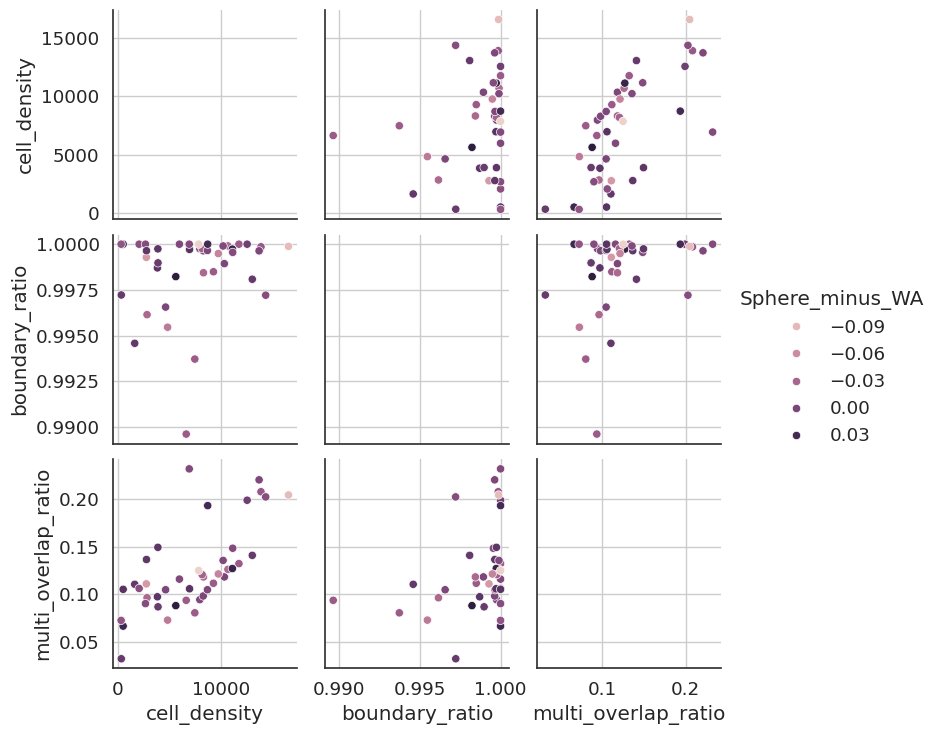

                     cell_density  boundary_ratio  multi_overlap_ratio  \
cell_density             1.000000        0.152893             0.688992   
boundary_ratio           0.152893        1.000000             0.306112   
multi_overlap_ratio      0.688992        0.306112             1.000000   
Sphere_minus_WA         -0.245069        0.052896            -0.102499   

                     Sphere_minus_WA  
cell_density               -0.245069  
boundary_ratio              0.052896  
multi_overlap_ratio        -0.102499  
Sphere_minus_WA             1.000000  


In [7]:
import geopandas as gpd
from shapely import wkt
from shapely.validation import make_valid

import pandas as pd
import geopandas as gpd
from shapely import wkt

def compute_patch_features(bin_path, cell_path, patch_area_um2=1_000_000, boundary_thresh=0.2):
    try:
        # === 读取 bin_gdf ===
        bin_gdf = pd.read_csv(bin_path)
        bin_gdf["geometry"] = bin_gdf["geometry"].apply(wkt.loads)
        bin_gdf = gpd.GeoDataFrame(bin_gdf, geometry="geometry")  # 激活 geometry 列

        # === 读取 cell_gdf ===
        cell_gdf = pd.read_csv(cell_path)
        cell_gdf["geometry"] = cell_gdf["geometry"].apply(wkt.loads)
        cell_gdf = gpd.GeoDataFrame(cell_gdf, geometry="geometry")

        # cell_density
        num_cells = cell_gdf.shape[0]
        cell_density = num_cells / (patch_area_um2 / 1_000_000)  # cell/mm²

        # 边界 cell 比例
        sj = gpd.sjoin(bin_gdf, cell_gdf, how="inner", predicate="intersects")
        bin_counts = sj.groupby("cell_id").size()

        inside_counts = sj[sj.apply(lambda r: r["geometry"].within(cell_gdf.loc[r["index_right"], "geometry"]), axis=1)] \
                             .groupby("cell_id").size()

        boundary_cells = [cid for cid in bin_counts.index
                          if inside_counts.get(cid, 0) / bin_counts[cid] < (1 - boundary_thresh)]
        boundary_ratio = len(boundary_cells) / num_cells if num_cells > 0 else 0

        # 多细胞 overlap bin 比例
        bin_overlap_counts = sj.groupby(sj.index).size()
        multi_overlap_ratio = (bin_overlap_counts > 1).sum() / bin_gdf.shape[0] if bin_gdf.shape[0] > 0 else 0

        return cell_density, boundary_ratio, multi_overlap_ratio

    except Exception as e:
        print(f"[特征计算跳过] {bin_path}: {e}")
        return None, None, None


# ===== 主计算 =====
features = []
bins_dir = "/home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf"

for patch in os.listdir(bins_dir):
    if not patch.endswith(".csv"):
        continue
    bin_path = os.path.join(bins_dir, patch)
    cell_path = bin_path.replace("bins_gdf", "cells_gdf")
    if not os.path.exists(cell_path):
        continue
    cell_density, boundary_ratio, multi_overlap_ratio = compute_patch_features(
        bin_path, cell_path, patch_area_um2=1_000_000, boundary_thresh=0.2
    )
    features.append({
        "patch": patch,
        "cell_density": cell_density,
        "boundary_ratio": boundary_ratio,
        "multi_overlap_ratio": multi_overlap_ratio
    })

df_features = pd.DataFrame(features)

# 合并 Sphere_minus_WA
df_sphere = pd.read_csv("patch_comparison_sphere_vs_wa.csv")
df_merge = pd.merge(df_features, df_sphere, on="patch", how="inner")

# 保存合并结果
df_merge.to_csv("patch_features_with_sphere_gain.csv", index=False)
print(df_merge.head())

# ===== 画图示例 =====
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_merge, vars=["cell_density","boundary_ratio","multi_overlap_ratio"], hue="Sphere_minus_WA")
plt.show()

# 相关性分析
print(df_merge[["cell_density","boundary_ratio","multi_overlap_ratio","Sphere_minus_WA"]].corr())

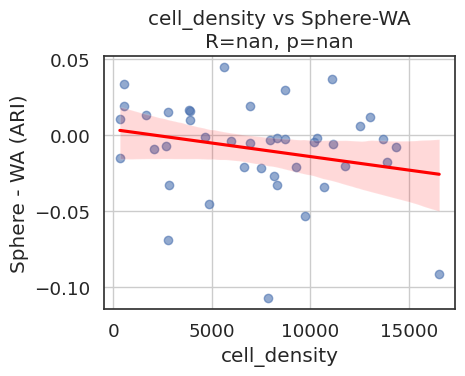

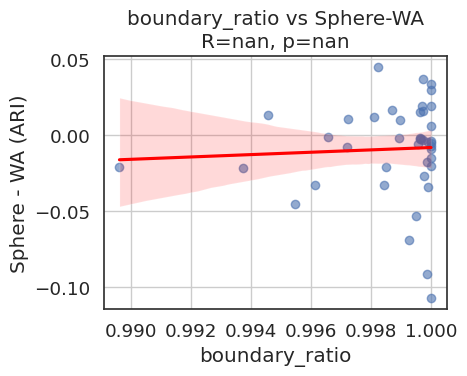

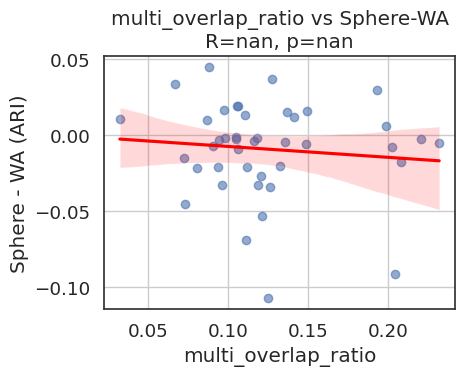

/tmp/ipykernel_15670/88932769.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",


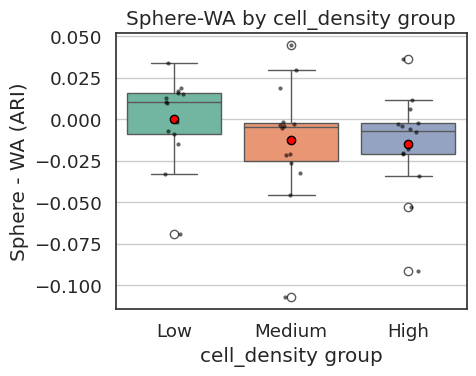

/tmp/ipykernel_15670/88932769.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",


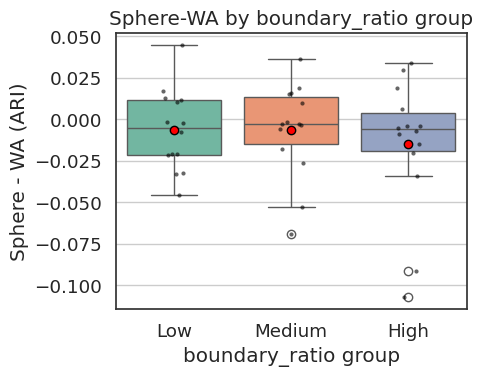

/tmp/ipykernel_15670/88932769.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",


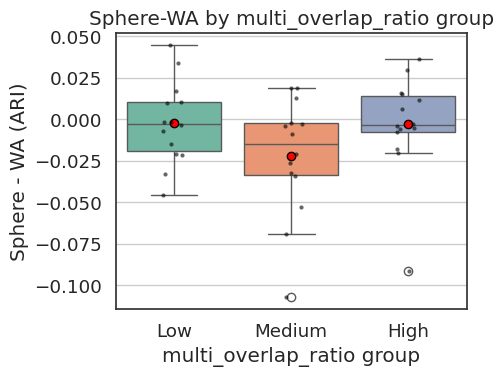

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 假设 df_merge 已经存在
features_to_plot = ["cell_density", "boundary_ratio", "multi_overlap_ratio"]

# ===== 1. 散点+回归拟合线 =====
for feat in features_to_plot:
    plt.figure(figsize=(5,4))
    sns.regplot(data=df_merge, x=feat, y="Sphere_minus_WA",
                scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    slope, intercept, r_value, p_value, std_err = linregress(df_merge[feat], df_merge["Sphere_minus_WA"])
    plt.title(f"{feat} vs Sphere-WA\nR={r_value:.2f}, p={p_value:.3g}")
    plt.xlabel(feat)
    plt.ylabel("Sphere - WA (ARI)")
    plt.tight_layout()
    plt.show()

# ===== 2. 分组箱线图 =====
# 按三分位数分组
for feat in features_to_plot:
    try:
        df_merge[f"{feat}_group"] = pd.qcut(df_merge[feat], q=3, labels=["Low", "Medium", "High"], duplicates='drop')
    except ValueError:
        df_merge[f"{feat}_group"] = pd.qcut(df_merge[feat], q=2, labels=["Low", "High"], duplicates='drop')
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",
                palette="Set2", showmeans=True,
                meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})

    sns.stripplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",
                  color="black", size=3, alpha=0.6)
    plt.title(f"Sphere-WA by {feat} group")
    plt.xlabel(feat + " group")
    plt.ylabel("Sphere - WA (ARI)")
    plt.tight_layout()
    plt.show()

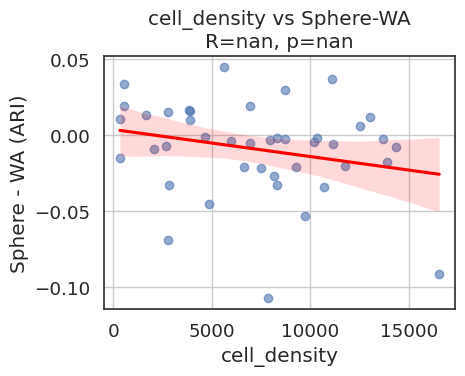

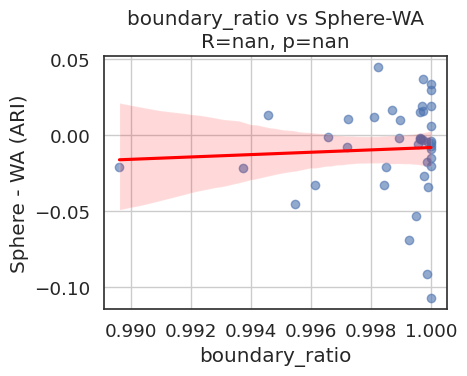

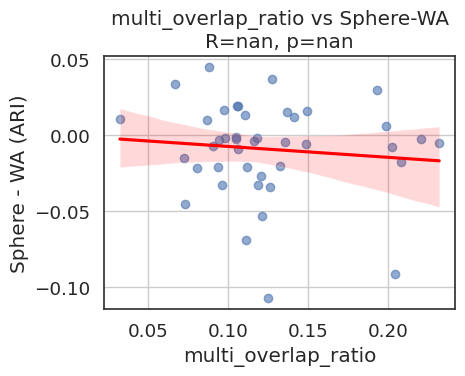

/tmp/ipykernel_15670/1749309573.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",


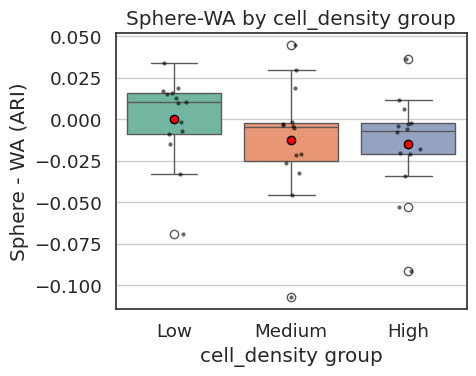

/tmp/ipykernel_15670/1749309573.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",


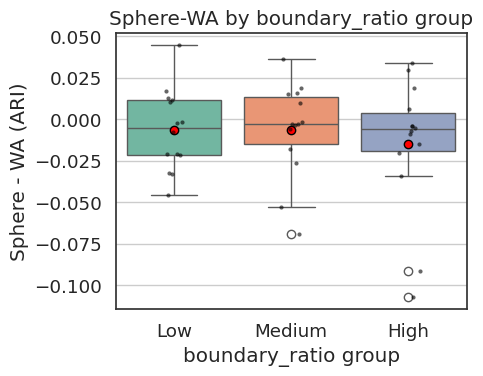

/tmp/ipykernel_15670/1749309573.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",


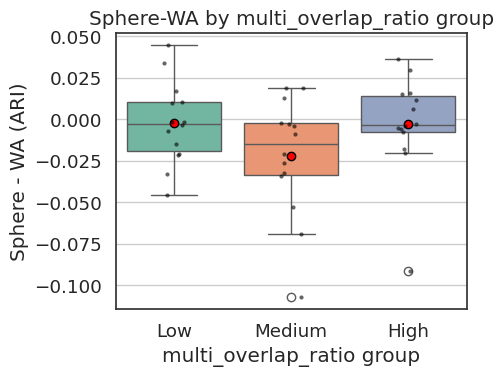

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

# 假设 df_merge 已经存在
features_to_plot = ["cell_density", "boundary_ratio", "multi_overlap_ratio"]

# ===== 1. 散点+回归拟合线 =====
for feat in features_to_plot:
    plt.figure(figsize=(5,4))
    sns.regplot(data=df_merge, x=feat, y="Sphere_minus_WA",
                scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    slope, intercept, r_value, p_value, std_err = linregress(df_merge[feat], df_merge["Sphere_minus_WA"])
    plt.title(f"{feat} vs Sphere-WA\nR={r_value:.2f}, p={p_value:.3g}")
    plt.xlabel(feat)
    plt.ylabel("Sphere - WA (ARI)")
    plt.tight_layout()
    plt.show()

# ===== 2. 分组箱线图 =====
# 更稳健的分组方法
for feat in features_to_plot:
    # 检查数据是否有足够的分组
    unique_values = df_merge[feat].nunique()
    
    if unique_values >= 3:
        # 尝试3分组
        try:
            df_merge[f"{feat}_group"] = pd.qcut(df_merge[feat], q=3, labels=["Low", "Medium", "High"], duplicates='drop')
        except:
            # 如果3分组失败，尝试等距分组
            df_merge[f"{feat}_group"] = pd.cut(df_merge[feat], bins=3, labels=["Low", "Medium", "High"])
    elif unique_values == 2:
        # 只有2个唯一值，直接分成两组
        df_merge[f"{feat}_group"] = pd.cut(df_merge[feat], bins=2, labels=["Low", "High"])
    else:
        # 只有一个值，无法分组
        print(f"Warning: Feature {feat} has only 1 unique value, skipping grouping.")
        continue
    
    # 绘制箱线图
    plt.figure(figsize=(5, 4))
    sns.boxplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",
                palette="Set2", showmeans=True,
                meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
    
    sns.stripplot(data=df_merge, x=f"{feat}_group", y="Sphere_minus_WA",
                  color="black", size=3, alpha=0.6)
    
    plt.title(f"Sphere-WA by {feat} group")
    plt.xlabel(feat + " group")
    plt.ylabel("Sphere - WA (ARI)")
    plt.tight_layout()
    plt.show()


如果你是做空间转录组或单细胞分析，可以根据你的研究重点选择

泛CRC上皮标记（EPCAM, KRT20, CEACAM5）

特定亚型标记（MUC2, VIM, FAP）

免疫浸润度相关标记（CD3D, CD68, PDCD1）


In [ ]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from matplotlib import rcParams
import string

# ======== 全局绘图参数 ========
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 12

# ===== Patch 列表 =====
patch_list = [
    "patch_0_2.csv", "patch_3_2.csv", "patch_8_4.csv", "patch_10_3.csv",
    "patch_9_4.csv", "patch_6_3.csv", "patch_1_3.csv", "patch_9_1.csv",
    "patch_8_0.csv", "patch_0_0.csv"
]

# ====== marker基因 ======
marker_genes_panel = [
    "EPCAM", "KRT20", 
    "MUC2", "VIM", "FAP",
    "CD3D", "CD68", "PDCD1"
]

# ====== 保存文件夹 ======
save_dir = "HumanCRC_cluster_comparison"
os.makedirs(save_dir, exist_ok=True)

# ====== 三种方法定义（保持不变） ======
def naive_assignment(bin_gdf, cell_gdf, common_genes):
    sj = gpd.sjoin(gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
                   gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
                   how="inner", predicate="within")
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    return sj.groupby("cell_id")[common_genes].sum()

def weighted_by_area(bin_gdf, cell_gdf, common_genes):
    sj = gpd.sjoin(gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
                   gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
                   how="inner", predicate="intersects")
    def safe_intersection(g1, g2):
        try: return g1.intersection(g2).area
        except: return 0
    sj["overlap_area"] = sj.apply(
        lambda r: safe_intersection(r["geometry"], cell_gdf.loc[r["index_right"], "geometry"]), axis=1)
    sj["bin_area"] = sj["geometry"].area
    sj["weight"] = sj["overlap_area"] / sj["bin_area"]
    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    weighted = sj[common_genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["cell_id"]
    return weighted.groupby("cell_id")[common_genes].sum()

def sphere_assignment(bin_gdf, cell_gdf, common_genes, alpha=0.01):
    sj = gpd.sjoin(gpd.GeoDataFrame(bin_gdf, geometry="geometry"),
                   gpd.GeoDataFrame(cell_gdf, geometry="geometry"),
                   how="inner", predicate="intersects")
    def safe_intersection(g1, g2):
        try: return g1.intersection(g2).area
        except: return 0
    sj["overlap_area"] = sj.apply(
        lambda r: safe_intersection(r["geometry"], cell_gdf.loc[r["index_right"], "geometry"]), axis=1)
    sj["bin_area"] = sj["geometry"].area
    sj["area_weight"] = sj["overlap_area"] / sj["bin_area"]

    # 距离权重
    sj["bin_cx"] = sj["geometry"].apply(lambda g: g.centroid.x)
    sj["bin_cy"] = sj["geometry"].apply(lambda g: g.centroid.y)
    cell_gdf["cx"] = cell_gdf["geometry"].apply(lambda g: g.centroid.x)
    cell_gdf["cy"] = cell_gdf["geometry"].apply(lambda g: g.centroid.y)
    sj["cell_cx"] = sj["index_right"].map(cell_gdf["cx"])
    sj["cell_cy"] = sj["index_right"].map(cell_gdf["cy"])
    sj["dist_weight"] = np.exp(-alpha * np.sqrt(
        (sj["bin_cx"] - sj["cell_cx"])**2 + (sj["bin_cy"] - sj["cell_cy"])**2))

    sj["raw_w"] = sj["area_weight"] * sj["dist_weight"]
    sj["weight"] = sj.groupby(sj.index)["raw_w"].transform(lambda x: x / x.sum())

    sj["cell_id"] = sj["index_right"].map(cell_gdf["cell_id"])
    weighted = sj[common_genes].multiply(sj["weight"], axis=0)
    weighted["cell_id"] = sj["cell_id"]
    return weighted.groupby("cell_id")[common_genes].sum()

# ====== 聚类 ======
def run_clustering(adata):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var["highly_variable"]]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=1.0)
    return adata

# ===== 处理每个 patch 和 每个 marker =====
for patch_id in patch_list:
    print(f"=== Processing {patch_id} ===")
    bin_path = f"/home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks/bins_gdf/{patch_id}"
    cell_path = bin_path.replace("bins_gdf", "cells_gdf")
    gt_path = bin_path.replace("bins_gdf", "ground_truth_nuclei")

    # 读取数据
    bin_gdf = pd.read_csv(bin_path)
    bin_gdf['geometry'] = bin_gdf['geometry'].apply(wkt.loads)
    cell_gdf = pd.read_csv(cell_path)
    cell_gdf['geometry'] = cell_gdf['geometry'].apply(wkt.loads)
    gt = pd.read_csv(gt_path).set_index("cell_id")
    gt = gt.apply(pd.to_numeric, errors='coerce').fillna(0)

    # 共同基因
    common_genes = sorted(list(set(bin_gdf.columns) & set(gt.columns) -
                               set(['assigned_bin_id', 'row', 'column', 'geometry'])))

    # 三种方法
    pred_naive = naive_assignment(bin_gdf, cell_gdf, common_genes)
    pred_wa = weighted_by_area(bin_gdf, cell_gdf, common_genes)
    pred_sphere = sphere_assignment(bin_gdf, cell_gdf, common_genes, alpha=0.01)
    methods = {
        "Naïve": pred_naive,
        "Weighted Area": pred_wa,
        "SPHERE": pred_sphere,
        "Ground Truth": gt[common_genes]
    }

    # 聚类
    adata_dict = {}
    for name, expr in methods.items():
        adata_dict[name] = run_clustering(sc.AnnData(expr))

    # 计算 ARI/NMI
    metrics = {}
    for name in ["Naïve", "Weighted Area", "SPHERE"]:
        common_ids = gt.index.intersection(methods[name].index)
        gt_labels_sub = adata_dict["Ground Truth"].obs.loc[common_ids, "leiden"]
        pred_labels_sub = adata_dict[name].obs.loc[common_ids, "leiden"]
        ari = adjusted_rand_score(gt_labels_sub, pred_labels_sub)
        nmi = normalized_mutual_info_score(gt_labels_sub, pred_labels_sub)
        metrics[name] = {"ARI": ari, "NMI": nmi}
    df_metrics = pd.DataFrame(metrics).T

    # 循环每个 marker 绘图
    for marker_gene in marker_genes_panel:
        fig = plt.figure(figsize=(24, 16))
        grid = fig.add_gridspec(3, 5, height_ratios=[1, 1, 0.8], width_ratios=[1, 1, 1, 1, 1])
        axes_umap = [fig.add_subplot(grid[0, i]) for i in range(4)]
        axes_spatial = [fig.add_subplot(grid[1, i]) for i in range(4)]
        ax_heatmap = fig.add_subplot(grid[2, 0:2])
        ax_extra = fig.add_subplot(grid[2, 2:5])

        # 第一行 UMAP
        for j, name in enumerate(methods.keys()):
            sc.pl.umap(adata_dict[name], color="leiden", title=f"{name} - UMAP",
                       ax=axes_umap[j], show=False, legend_loc=None, size=50)

        # 第二行 Spatial clustering
        coords = cell_gdf.set_index("cell_id").loc[gt.index].geometry
        for j, name in enumerate(methods.keys()):
            ad = adata_dict[name]
            ad.obs["geometry"] = coords
            gdf_plot = gpd.GeoDataFrame(ad.obs, geometry="geometry")
            gdf_plot.boundary.plot(ax=axes_spatial[j], color="lightgray", linewidth=0.2)
            gdf_points = gpd.GeoDataFrame(gdf_plot.copy(), geometry=gdf_plot.geometry.centroid)
            gdf_points.plot(column="leiden", categorical=True, legend=False,
                            cmap="tab20", markersize=30, ax=axes_spatial[j])
            axes_spatial[j].set_facecolor("white")
            axes_spatial[j].set_title(f"{name} - Spatial Clustering")
            axes_spatial[j].axis('off')

        # 热图
        sns.heatmap(df_metrics, annot=True, cmap="YlGnBu", fmt=".3f",
                    annot_kws={"size": 12, "weight": "bold"},
                    cbar_kws={"label": "Score"}, ax=ax_heatmap)
        ax_heatmap.set_title("Clustering Similarity Metrics vs Ground Truth")

        # Marker 基因图
        if marker_gene not in common_genes:
            ax_extra.set_title(f"{marker_gene} not found")
            ax_extra.axis('off')
        else:
            coords = cell_gdf.set_index("cell_id").loc[gt.index].geometry
            ad_gt = adata_dict["Ground Truth"].copy()
            expr_values = ad_gt[:, marker_gene].X
            if hasattr(expr_values, "toarray"):
                expr_values = expr_values.toarray().flatten()
            else:
                expr_values = np.array(expr_values).flatten()
            ad_gt.obs[marker_gene] = expr_values
            gdf_marker = gpd.GeoDataFrame(ad_gt.obs, geometry=gpd.GeoSeries(coords))
            gdf_marker_points = gpd.GeoDataFrame(gdf_marker.copy(), geometry=gdf_marker.geometry.centroid)
            gdf_marker_points.plot(column=marker_gene, cmap="viridis", markersize=10,
                                   legend=True, ax=ax_extra)
            ax_extra.set_facecolor("white")
            ax_extra.set_title(f"{marker_gene} expression")
            ax_extra.axis('off')

        # 标签
        labels = list(string.ascii_lowercase)
        for idx, ax in enumerate(axes_umap + axes_spatial + [ax_heatmap, ax_extra]):
            ax.annotate(labels[idx], xy=(0, 1.05), xycoords='axes fraction',
                        fontsize=14, fontweight='bold', va='bottom', ha='left')

        plt.tight_layout()
        out_pdf = os.path.join(save_dir, f"HumanCRC_cluster_comparison_{patch_id}_{marker_gene}.pdf")
        out_png = os.path.join(save_dir, f"HumanCRC_cluster_comparison_{patch_id}_{marker_gene}.png")
        plt.savefig(out_pdf, dpi=300, bbox_inches='tight')
        plt.savefig(out_png, dpi=300, bbox_inches='tight')
        plt.close()

=== Processing patch_0_2.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-09-10 09:42:38.117887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 09:42:38.123992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757468558.130219   576

=== Processing patch_3_2.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_8_4.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_10_3.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_9_4.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_6_3.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_1_3.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_9_1.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_8_0.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy

=== Processing patch_0_0.csv ===


/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wangzhuo/miniconda3/envs/spatial_310/lib/python3.10/site-packages/scanpy